In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils import data
from torch.utils.data import random_split,DataLoader
import string
from PIL import Image
import matplotlib.pyplot as plt
import time
import shutil
from torchvision import datasets, transforms
from tqdm.auto import tqdm

In [2]:
USE_CUDA = torch.cuda.is_available()

print("Device : {0}".format("GPU" if USE_CUDA else "CPU"))
device = torch.device("cuda" if USE_CUDA else "cpu")
cpu_device = torch.device("cpu")

BATCH_SIZE=128
VAL_SPLIT=0.2

AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=2
LATENT_DIM=256
ENCODER_SHAPE=16*56*184

CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26+10
OUTPUT_LENGTH=6

SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS=40
epoch_count = [i for i in range(1,EPOCHS+1)]

Device : GPU


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU(s):", torch.cuda.device_count())
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU(s): 2


In [4]:
data = '/kaggle/input/captchaimgdata/trainset'

In [5]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
import string
import zipfile

def get_dataloaders(data_dir, batch_size=64, val_split=0.2, shuffle=True, num_workers=0):
    #torch.manual_seed(42)
    #torch.cuda.manual_seed(42)
    # Define the character set (vocabulary)
    characters = string.ascii_uppercase + string.digits  # Uppercase + lowercase + digits
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    vocab_size = len(characters)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            self.labels = [os.path.basename(f).split('.')[0].upper() for f in self.image_paths]  # Extract filename as label

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label_str = self.labels[idx]

            # Convert label string to one-hot encoded tensor
            label_indices = [char_to_idx[c] for c in label_str if c in char_to_idx]  # Map characters to indices
            label_tensor = torch.zeros(len(label_indices),dtype=torch.long)  # One-hot encoding tensor
            for i, index in enumerate(label_indices):
                label_tensor[i] = index  # Set one-hot encoding

            if self.transform:
                image = self.transform(image)

            return image, label_tensor

    transform = transforms.Compose([
        transforms.Resize((64,192)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Lambda(lambda x: x / 255),
    ])

    dataset = CustomDataset(root_dir=data_dir, transform=transform)
    print(f"Dataset size: {len(dataset)}")  # Print dataset size

    # Compute train-validation split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader

In [6]:
train_loader,val_loader=get_dataloaders(data_dir= data, batch_size=BATCH_SIZE, val_split=0.2, shuffle=True)

Dataset size: 26155


In [7]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 1, 64, 192]), torch.Size([128, 6]))

In [8]:
def accuracy_fn(y_true, y_pred):
            y_true = y_true.cpu()  
            y_pred = y_pred.cpu()

            y_true = y_true.view(-1)  
            y_pred = y_pred.view(-1)  

            correct = torch.eq(y_true, y_pred).sum().item()
            total_samples = len(y_true) 

            acc = (correct / total_samples)*100
            return acc

In [9]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )

class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [10]:
class VAE(nn.Module):
    def __init__(self, n, latent_dim,encoder_shape):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.n = n
        self.alpha = nn.Parameter(torch.randn(n - 1)).to(device)
        self.encoders = []
        for i in range(1, n + 1):
            self.encoders.append(Encoder(i, AFFN_KERNEL, AFFN_STRIDE).to(device))
        self.decoders = []
        for i in range(n, 0, -1):
            self.decoders.append(Decoder(i, AFFN_KERNEL, AFFN_STRIDE).to(device))
        self.fc_mu = nn.LazyLinear(latent_dim)
        self.fc_logvar = nn.LazyLinear(latent_dim)
        self.flat_layer = nn.Flatten(1,3)
        #ENCODER_SHAPE=16*56*184
        self.linear = nn.Linear(latent_dim,encoder_shape)
    def parameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x= x * (1 - self.alpha[i])
                residuals.append(x * self.alpha[i])
    
        batch,a,b,c=x.shape
        x= self.flat_layer(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.parameterize(mu, logvar)
        z = self.linear(z)
        unflatten = torch.nn.Unflatten(1,(a,b,c))
        x = unflatten(z)
        for i, dec in enumerate(self.decoders):
            x = dec(x)
            if i < self.n - 1:           
                x = x + residuals.pop() 
        return x, mu, logvar
        
def loss_function(reconstructed_x, y, mu, logvar):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_x, y, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_div

In [11]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  
        self.vocab_size = vocab_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)

        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)

        lstm_input = latent.unsqueeze(1)

        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)

        outputs = []

        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)

            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)

            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 6, vocab_size)

        return outputs

In [12]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.VAE = VAE(AFFN_DEPTH,LATENT_DIM,ENCODER_SHAPE).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                )

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        out,mu,logvar=self.VAE(x)
        res_out=self.res(x)
        conv1_out=self.conv1(out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output


In [13]:
def train(model,train_loader,val_loader,epochs=EPOCHS):
    #torch.manual_seed(42)
    #torch.cuda.manual_seed(42)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    model.to(device)
    train_history=[]
    val_history=[]
    train_acc=[]
    val_acc=[]
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        avg_acc=0
        avg_loss=0
        model.train()
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):

            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X)

            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()

            avg_loss+=loss.item()
            avg_acc+=accuracy_fn(y_true=y.cpu(),y_pred=torch.argmax(preds,dim=2).cpu())


        avg_loss/=len(train_loader)
        avg_acc/=len(train_loader)
        train_acc.append(avg_acc)
        print(f"Train Acc: {avg_acc}%")
        train_history.append(avg_loss)
        print(f"Train Loss: {avg_loss}")

        eval_loss=0
        eval_acc=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
                    eval_acc+=accuracy_fn(y_true=y,y_pred=torch.argmax(preds,dim=2))
                    eval_loss+=loss.item()
                eval_acc/=len(val_loader)
                val_acc.append(eval_acc)
                print(f"Val Acc: {eval_acc}%")
                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}")


        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')

    return train_history,val_history,train_acc,val_acc


In [14]:
model=CaptchaCrackNet().to(device)

train_history,val_history,train_acc,val_acc =train(model,train_loader,val_loader,EPOCHS)

Epoch 1:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 2.3362339092140925%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 2:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9841421070460719%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 3:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.982342479674795%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 4:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9850419207317067%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 5:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9805428523035222%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 6:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9859417344173442%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 7:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9877413617886184%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 8:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9841421070460714%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 9:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9850419207317074%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 10:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9841421070460696%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Saving model
Epoch 11:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9814426659891602%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 12:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9823424796747962%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 13:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9814426659891593%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 14:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9841421070460696%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 15:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9832422933604348%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 16:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.981442665989161%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 17:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9823424796747968%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 18:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9850419207317076%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 19:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9841421070460703%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 20:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.984142107046071%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Saving model
Epoch 21:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9832422933604341%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 22:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9841421070460719%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 23:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9832422933604328%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 24:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.985041920731707%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 25:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.983242293360433%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 26:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9832422933604328%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 27:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.983242293360434%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 28:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.984142107046069%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 29:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9823424796747962%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 30:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.980542852303523%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Saving model
Epoch 31:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.980542852303523%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 32:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9850419207317074%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 33:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9832422933604335%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 34:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9823424796747986%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 35:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.980542852303523%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 36:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9814426659891595%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 37:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9823424796747966%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 38:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9832422933604335%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 39:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.9823424796747966%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Epoch 40:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 1.985941734417345%
Train Loss: nan


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 2.01269295209844%
Val Loss: nan
Saving model


In [15]:
loaded_model = CaptchaCrackNet() 

state_dict = torch.load('final.pth', map_location=torch.device('cpu')) 

loaded_model.load_state_dict(state_dict) 

loaded_model.eval()

CaptchaCrackNet(
  (VAE): VAE(
    (fc_mu): LazyLinear(in_features=0, out_features=256, bias=True)
    (fc_logvar): LazyLinear(in_features=0, out_features=256, bias=True)
    (flat_layer): Flatten(start_dim=1, end_dim=3)
    (linear): Linear(in_features=256, out_features=164864, bias=True)
  )
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1

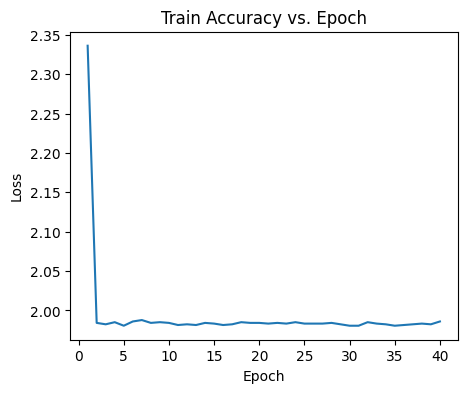

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(epochs,losses,predictions=None):
  plt.figure(figsize=(5,4))
  plt.plot(epochs, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train Accuracy vs. Epoch')
  plt.show()
plot_predictions(epoch_count,train_acc)

In [17]:
characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

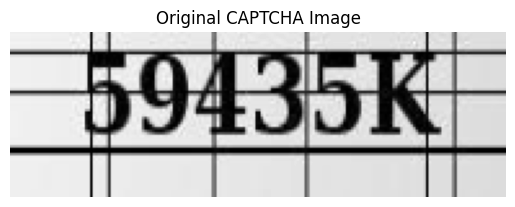

True : 59435K
Pred : A


In [18]:
from itertools import groupby

def to_text(pred_tensor):
    pred_indices = pred_tensor.cpu().numpy().tolist()
    result = ''.join([idx_to_char[idx] for idx, _ in groupby(pred_indices) if idx != VOCAB_SIZE - 1])
    return result

import matplotlib.pyplot as plt

model.eval()  # Set to eval mode

with torch.no_grad():
    for X, y in train_loader:
        # Select one sample
        X_single = X[0]
        y_single = y[0]

        # Show original image
        plt.imshow(X_single.numpy().squeeze(), cmap='gray')
        plt.title("Original CAPTCHA Image")
        plt.axis("off")
        plt.show()

        # Model output
        input_tensor = X_single.unsqueeze(0).to(device)
        output = model(input_tensor)  # [W, B, VOCAB_SIZE]
        output = F.log_softmax(output, dim=2)
        pred = output.argmax(dim=2).squeeze(1)  # [W]

        # Decode prediction
        pred_text=''
        for i in pred:
            pred_text+= to_text(i)
        true_text = ''.join([idx_to_char[c.item()] for c in y_single if c.item() != -1])

        print(f"True : {true_text}")
        print(f"Pred : {pred_text}")
        break

In [19]:
def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Collecting predictions"):
            images = images.to(device)
            outputs = model(images)
            outputs = F.log_softmax(outputs, dim=2)
            preds = outputs.argmax(dim=2).permute(1, 0)  # [B, W]

            all_preds.extend(preds.cpu())
            all_targets.extend(labels.cpu())

    return all_preds, all_targets

In [20]:
val_preds, val_targets = get_predictions_and_labels(model, val_loader)

In [21]:
preds = []
targets = []
for i in val_preds:
    for j in i:
        preds.append(j.item())
for i in val_targets:
    for j in i:
        targets.append(j.item())

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
def Confmatrix(y_pred,targets):
    confmat = ConfusionMatrix(num_classes=VOCAB_SIZE, task='multiclass')
    y_pred = torch.tensor(y_pred, dtype=torch.int64) 
    targets = torch.tensor(targets, dtype=torch.int64)
    
    confmat_tensor = confmat(preds=y_pred,target=targets) 

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.cpu().numpy(), # Convert back to NumPy for plotting
        class_names=list(characters), # turn the row and column labels into class names
        figsize=(10, 7)
    );
   

/usr/local/lib/python3.11/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


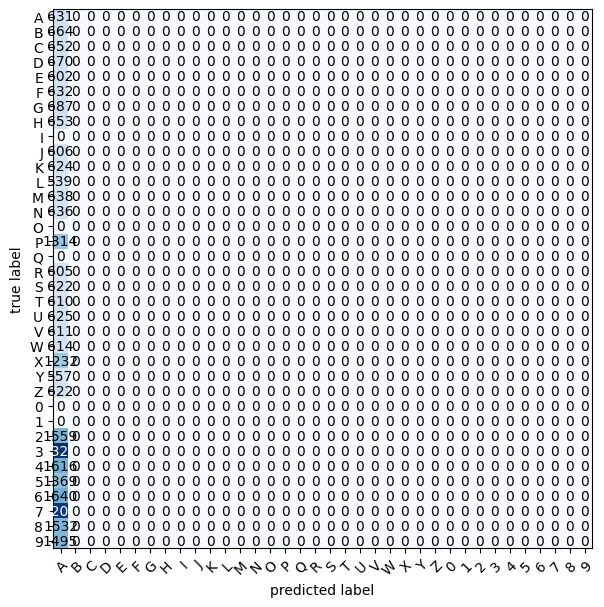

In [23]:
Confmatrix(preds,targets)